In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta, datetime

import numpy as np
import pandas as pd
import jax.numpy as jnp

import mechafil.data as mecha_data
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_sector_expirations, get_cum_capped_qa_power, setup_spacescope
import mechafil.sim as np_sim
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df
import mechafil.locking as locking

import scenario_generator.utils as u
import scenario_generator.curated as curated

"""
Ensure that mechafil is on "sdm_take2_analysis" branch to properly run this notebook
"""

'\nEnsure that mechafil is on "sdm_take2_analysis" branch to properly run this notebook\n'

In [4]:
save_dir = '/Users/kiran/Documents/baseline_project'
os.makedirs(save_dir, exist_ok=True)

In [30]:
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [5]:
start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
mecha_data.setup_spacescope(token)

fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date, end_date)

In [21]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(start_date, current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(start_date, current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

5.85205078125 0.7740567899254742 0.9183962581565727


<IPython.core.display.Javascript object>


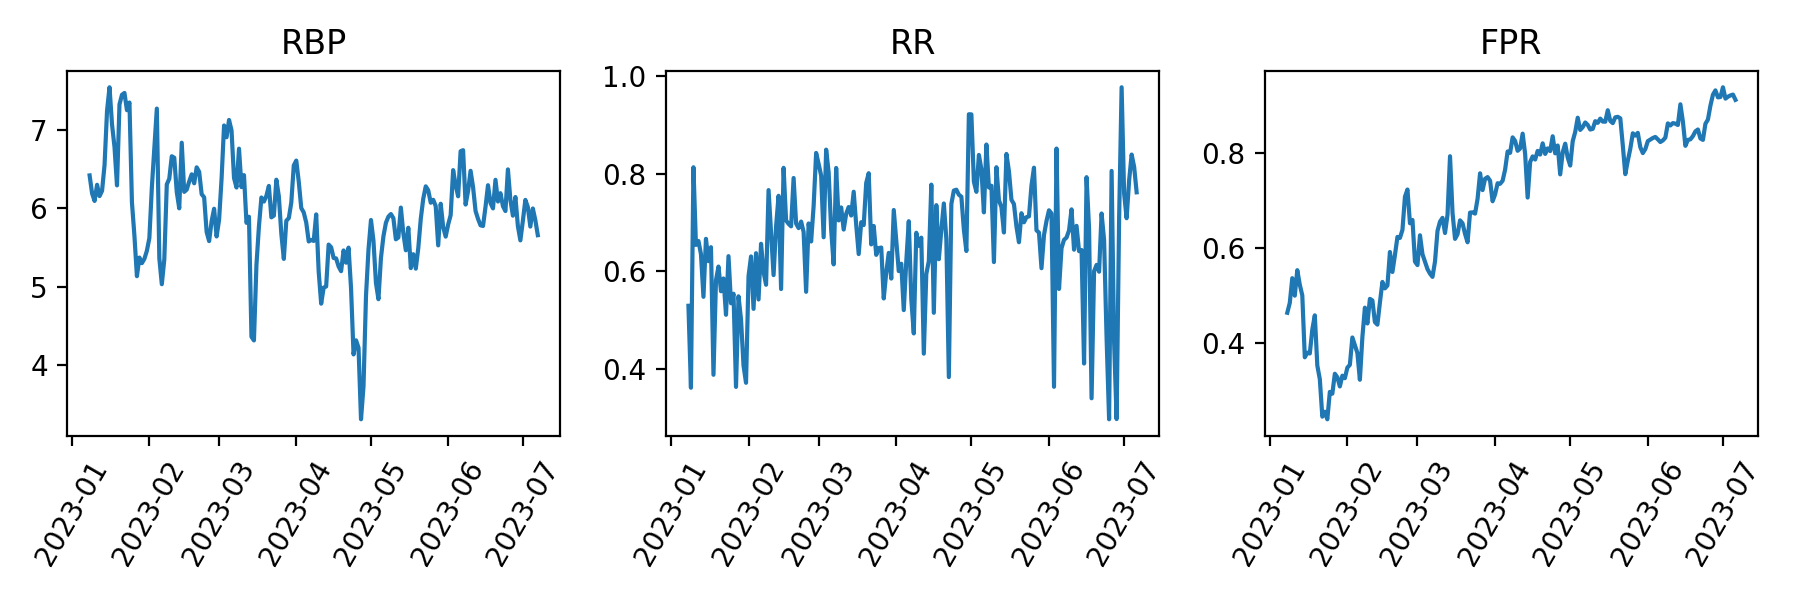

In [7]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()

In [26]:
def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
#             df_out[c] = df_out[c].clip(lower=0)
    return df_out

def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    return cil_rbp


def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            simulation_name='abc',
            duration=540, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    # force spacescope setup since this is run in a separate process
    setup_spacescope(token)
    
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([hist_rr, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_length):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_length,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_hist_fpr, hist_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_hist_fpr, hist_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN,
        'sim_name': simulation_name
    }
    
    return return_dict

In [52]:
intervention_date=current_date+timedelta(days=1)
no_sdm = lambda d: 1
num_days_shock_behavior = 360
days_to_target=1

qap_mode = 'basic-sdm'

current_rbp = hist_rbp[-1]
current_rr = hist_rr[-1]

# configure for no-sdm but remove b(t) from baseline QAP pledge
no_baseline_cfg = {
    'duration': 540,  # a noop 
    'duration_m': no_sdm, 
    'qap_mode': 'basic-sdm',      
    'intervention_config': {
        'type': 'noop',
        'num_days_shock_behavior': num_days_shock_behavior,
        'intervention_date': intervention_date,
        'simulation_start_date': current_date + timedelta(days=1),
        'sdm_onboard_before_intervention': False,
        'sdm_onboard_after_intervention': False,
        'sdm_renew_before_intervention': False,
        'sdm_renew_after_intervention': False,
        'lock_target_update_date': intervention_date,
        'lock_target_update_value': 0.3,
        'consensus_pledge_method_before_intervention': 'circulating_supply',
        'consensus_pledge_method_after_intervention': 'circulating_supply',
        'onboard_ratio_callable': locking.no_baseline_onboard_ratio,
        
    }
}

In [53]:
# create scenarios
g = np.log(2)/(365)
constant_scenarios = {
    '0.25x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.25,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*2,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
    
}
linear_scenarios = {
    '0.25x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.25,# + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.5,# + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp,# + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*2,# + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*5,# + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}
exponential_scenarios = {
    '2x': {
        'rbp': smoothed_last_historical_rbp*np.exp(g*np.arange(forecast_length)),# + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*0.59)*np.arange(forecast_length)),# + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*1.325)*np.arange(forecast_length)),# + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

In [94]:
constant_labels = [
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.25x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.5x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['1x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['2x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['5x']['rbp']),)
]
linear_labels = [
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.25x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.5x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['1x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['2x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['5x']['rbp'])*365,))
]
exp_labels = [
    'Growth=1.5x/Yr',
    'Growth=2x/Yr',
    'Growth=2.5x/Yr'
]

In [56]:
scenario_vector = [
    ('constant', constant_scenarios),
    ('linear', linear_scenarios),
    ('exponential', exponential_scenarios),
]
scenario_results = {}

for n, scenario_dict in scenario_vector:
    sweep_results = {}
    for scenario_name, trajectories in scenario_dict.items():

        rbp = trajectories['rbp']
        rr = trajectories['rr']
        fpr = trajectories['fpr']
        
        return_dict = run_sim(
            rbp, 
            rr, 
            fpr,
            simulation_name=scenario_name,
            duration=540, 
            duration_m=None, 
            qap_mode='basic', 
            intervention_config=no_baseline_cfg['intervention_config']
        )

        sweep_results[scenario_name] = return_dict['rbp_roi']
    scenario_results[n] = sweep_results

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

In [57]:
def plot_x(ax, results, key, labels, colors, scale_by=1, start_idx=0):
    sweep_keys = list(results.keys())
    for ii, scenario in enumerate(sweep_keys):
        res = results[scenario]
        ax.plot(res['date'].iloc[start_idx:], res[key].iloc[start_idx:]/scale_by, label=labels[ii], color=colors[ii])
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

In [103]:
def plot_scenario_results(key='constant', log_scale_power=True, labels=None):
    scenario2results = scenario_results[key]
    subkeys = list(scenario2results.keys())
#     labels = list(scenario2results.keys())
    keys = list(scenario2results.keys())
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,10))

    c_vec = [c(0.6) for c in colors]

    axx = ax[0,0]
    plot_x(axx, scenario2results, 'network_RBP', labels, c_vec, scale_by=EIB)
#     axx.plot(t, baseline, linestyle=':', label='Baseline')
#     axx.set_yscale('log')
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    axx.legend(fontsize=8)
    if log_scale_power:
        axx.plot(scenario2results[subkeys[0]]['date'], scenario2results[subkeys[0]]['network_baseline']/EIB, linestyle=':', label='Baseline')
        axx.set_yscale('log')
        axx.set_ylim(0)
        
    axx = ax[0,1]
    plot_x(axx, scenario2results, 'network_QAP', labels, c_vec, scale_by=EIB)
#     axx.plot(t, baseline, linestyle=':', label='Baseline')
    axx.set_yscale('log')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    if log_scale_power:
        axx.plot(scenario2results[subkeys[0]]['date'], scenario2results[subkeys[0]]['network_baseline']/EIB, linestyle=':', label='Baseline')
        axx.set_yscale('log')
        axx.set_ylim(0)

    axx = ax[1,0]
    plot_x(axx, scenario2results, 'day_network_reward', labels, c_vec)
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    axx.set_ylim(0)

    axx = ax[1,1]
    plot_x(axx, scenario2results, 'network_locked', labels, c_vec, scale_by=1e6)
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.axhline(0, linestyle=':', color='k')
    axx.set_ylim(0)

    axx = ax[2,0]
    plot_x(axx, scenario2results, 'circ_supply', labels, c_vec, scale_by=1e6)
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    axx.set_ylim(0)

    axx = ax[2,1]
    for ii, sc in enumerate(keys):
        res = scenario2results[sc]
        axx.plot(res['date'], res['network_locked']/res['circ_supply'], label=labels[ii], color=c_vec[ii])
    for tick in axx.get_xticklabels():
        tick.set_rotation(60)
    axx.set_title('L/CS')
    axx.set_ylim(0)
    
    axx = ax[3,0]
    plot_x(axx, scenario2results, 'day_pledge_per_QAP', labels, c_vec, start_idx=1)
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    axx.set_ylim(0)
    
    axx = ax[3,1]
    plot_x(axx, scenario2results, '1y_sector_roi', labels, c_vec, scale_by=.01)
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    axx.set_ylim(0)
    
#     axx = ax[3,1]
#     for ii, sc in enumerate(labels):
#         res = scenario2results[sc]
#         axx.plot(t[:-364], res['1y_sector_roi']*100, label=labels[ii], color=c_vec[ii])
#     for tick in axx.get_xticklabels():
#         tick.set_rotation(60)
#     axx.set_ylabel('Fraction')
#     axx.set_title('1Y Realized FoFR')
#     axx.set_ylim(0)
    
    plt.suptitle('%s Onboarding Scenarios \n no b(t)' % (key.upper(),))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, '%s_locked_trajectories_nopledgedenom.png' % (key,)))

<IPython.core.display.Javascript object>


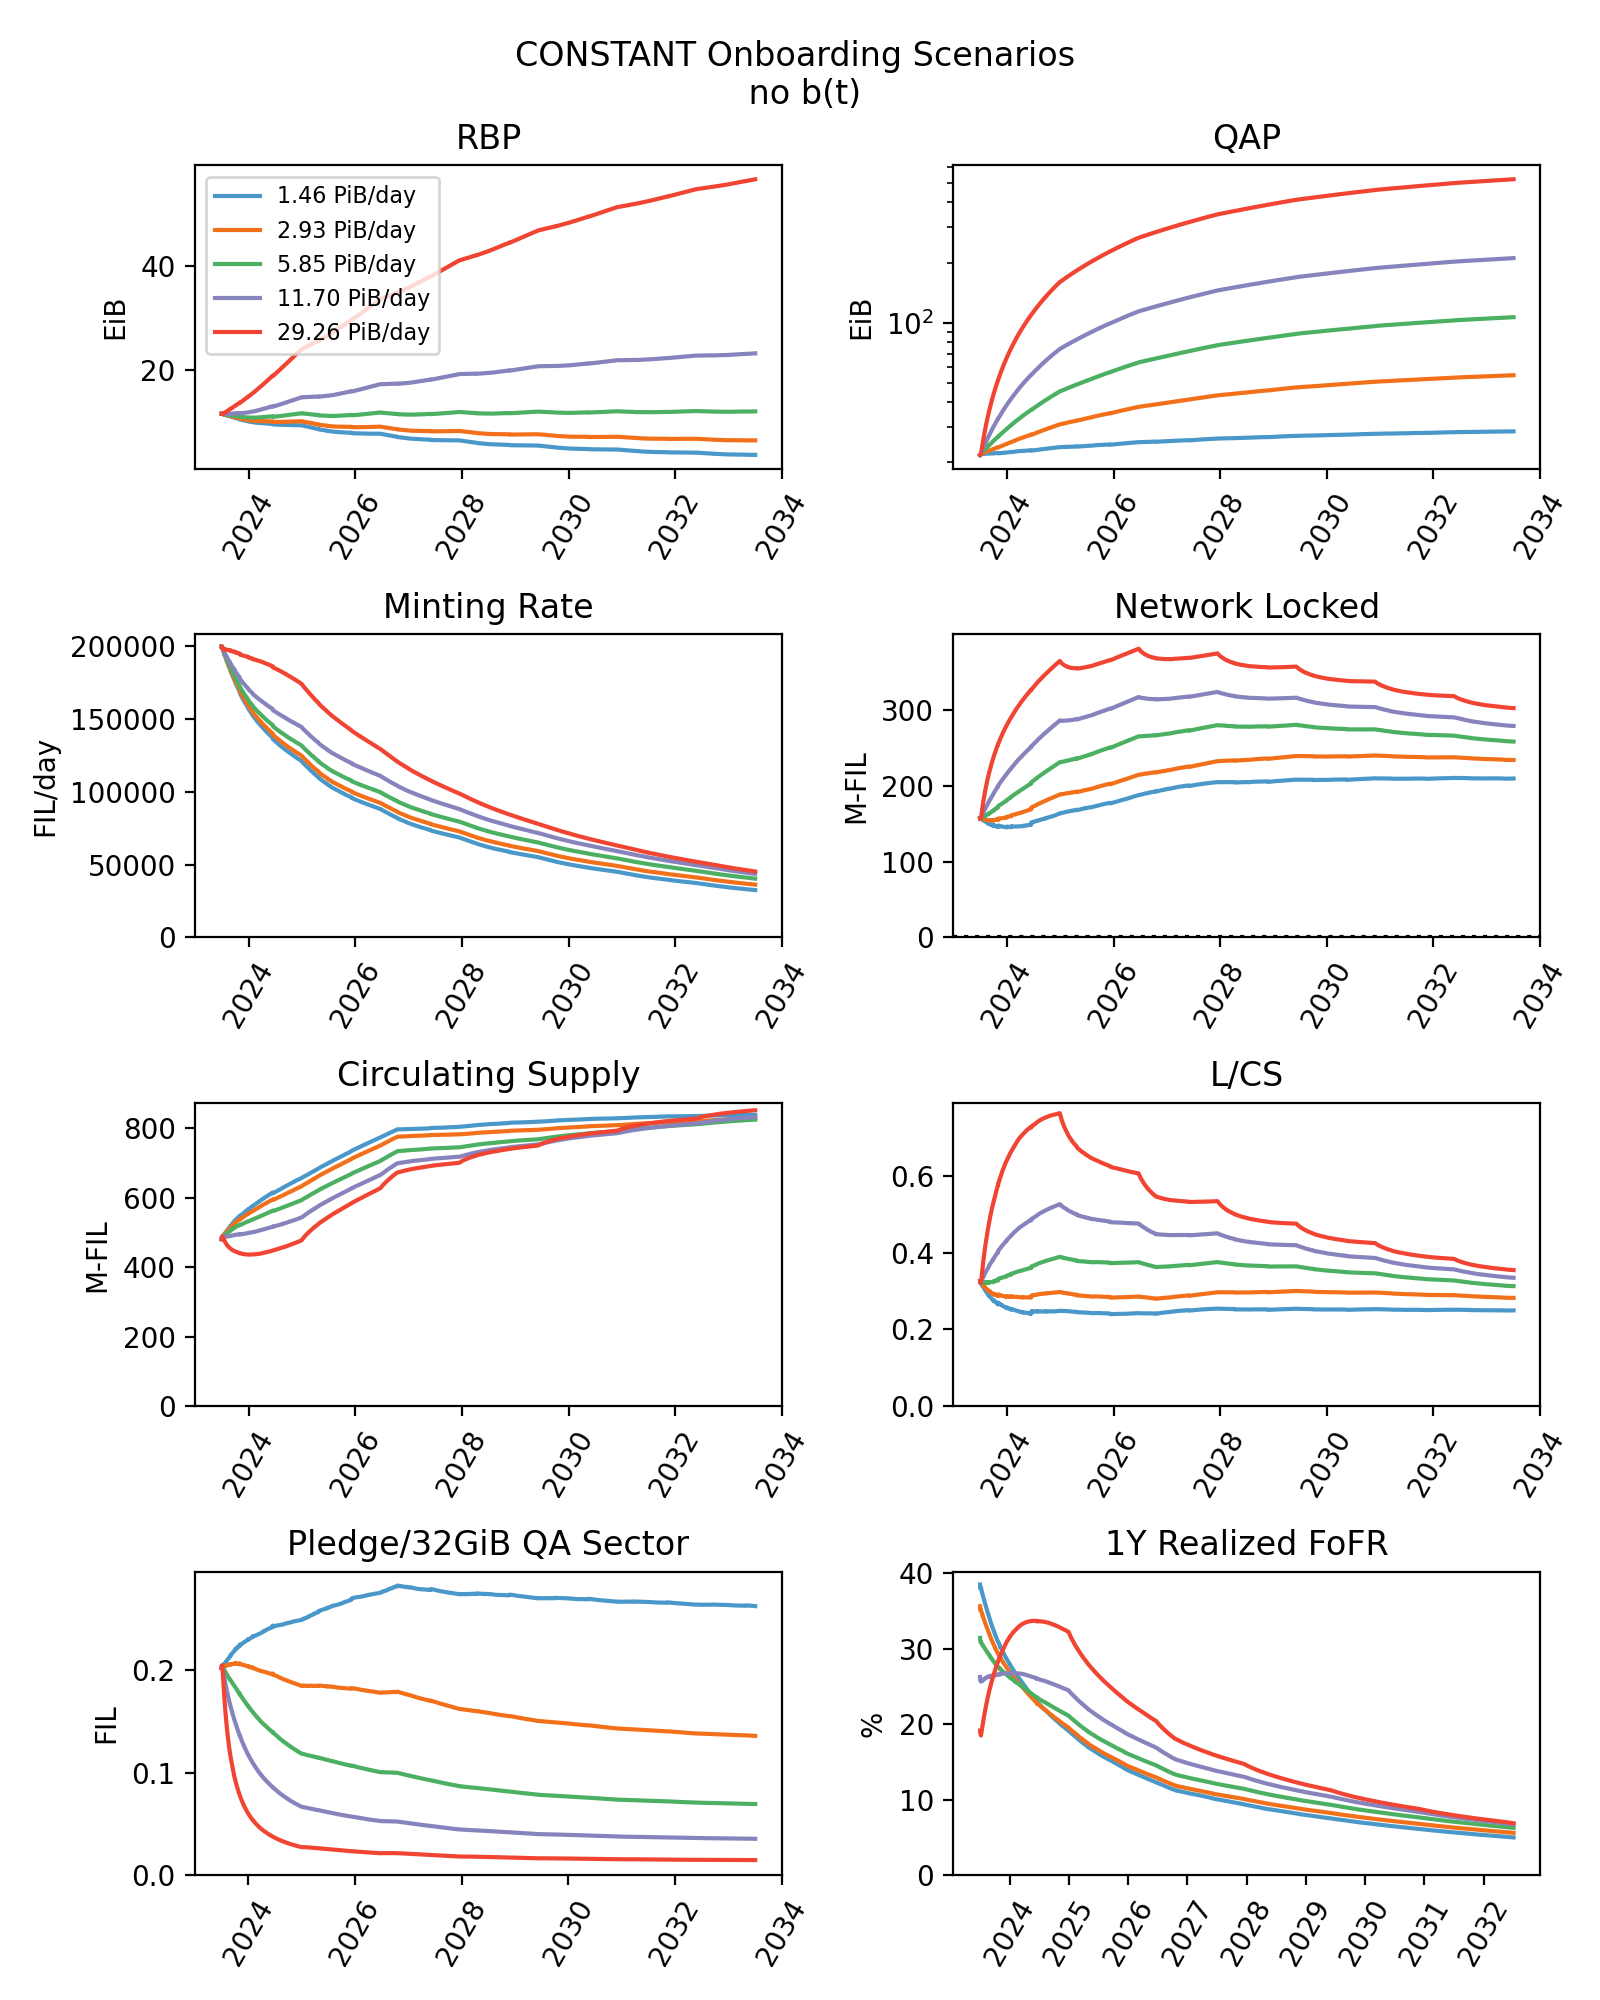

In [104]:
plot_scenario_results(key='constant', log_scale_power=False, labels=constant_labels)

<IPython.core.display.Javascript object>


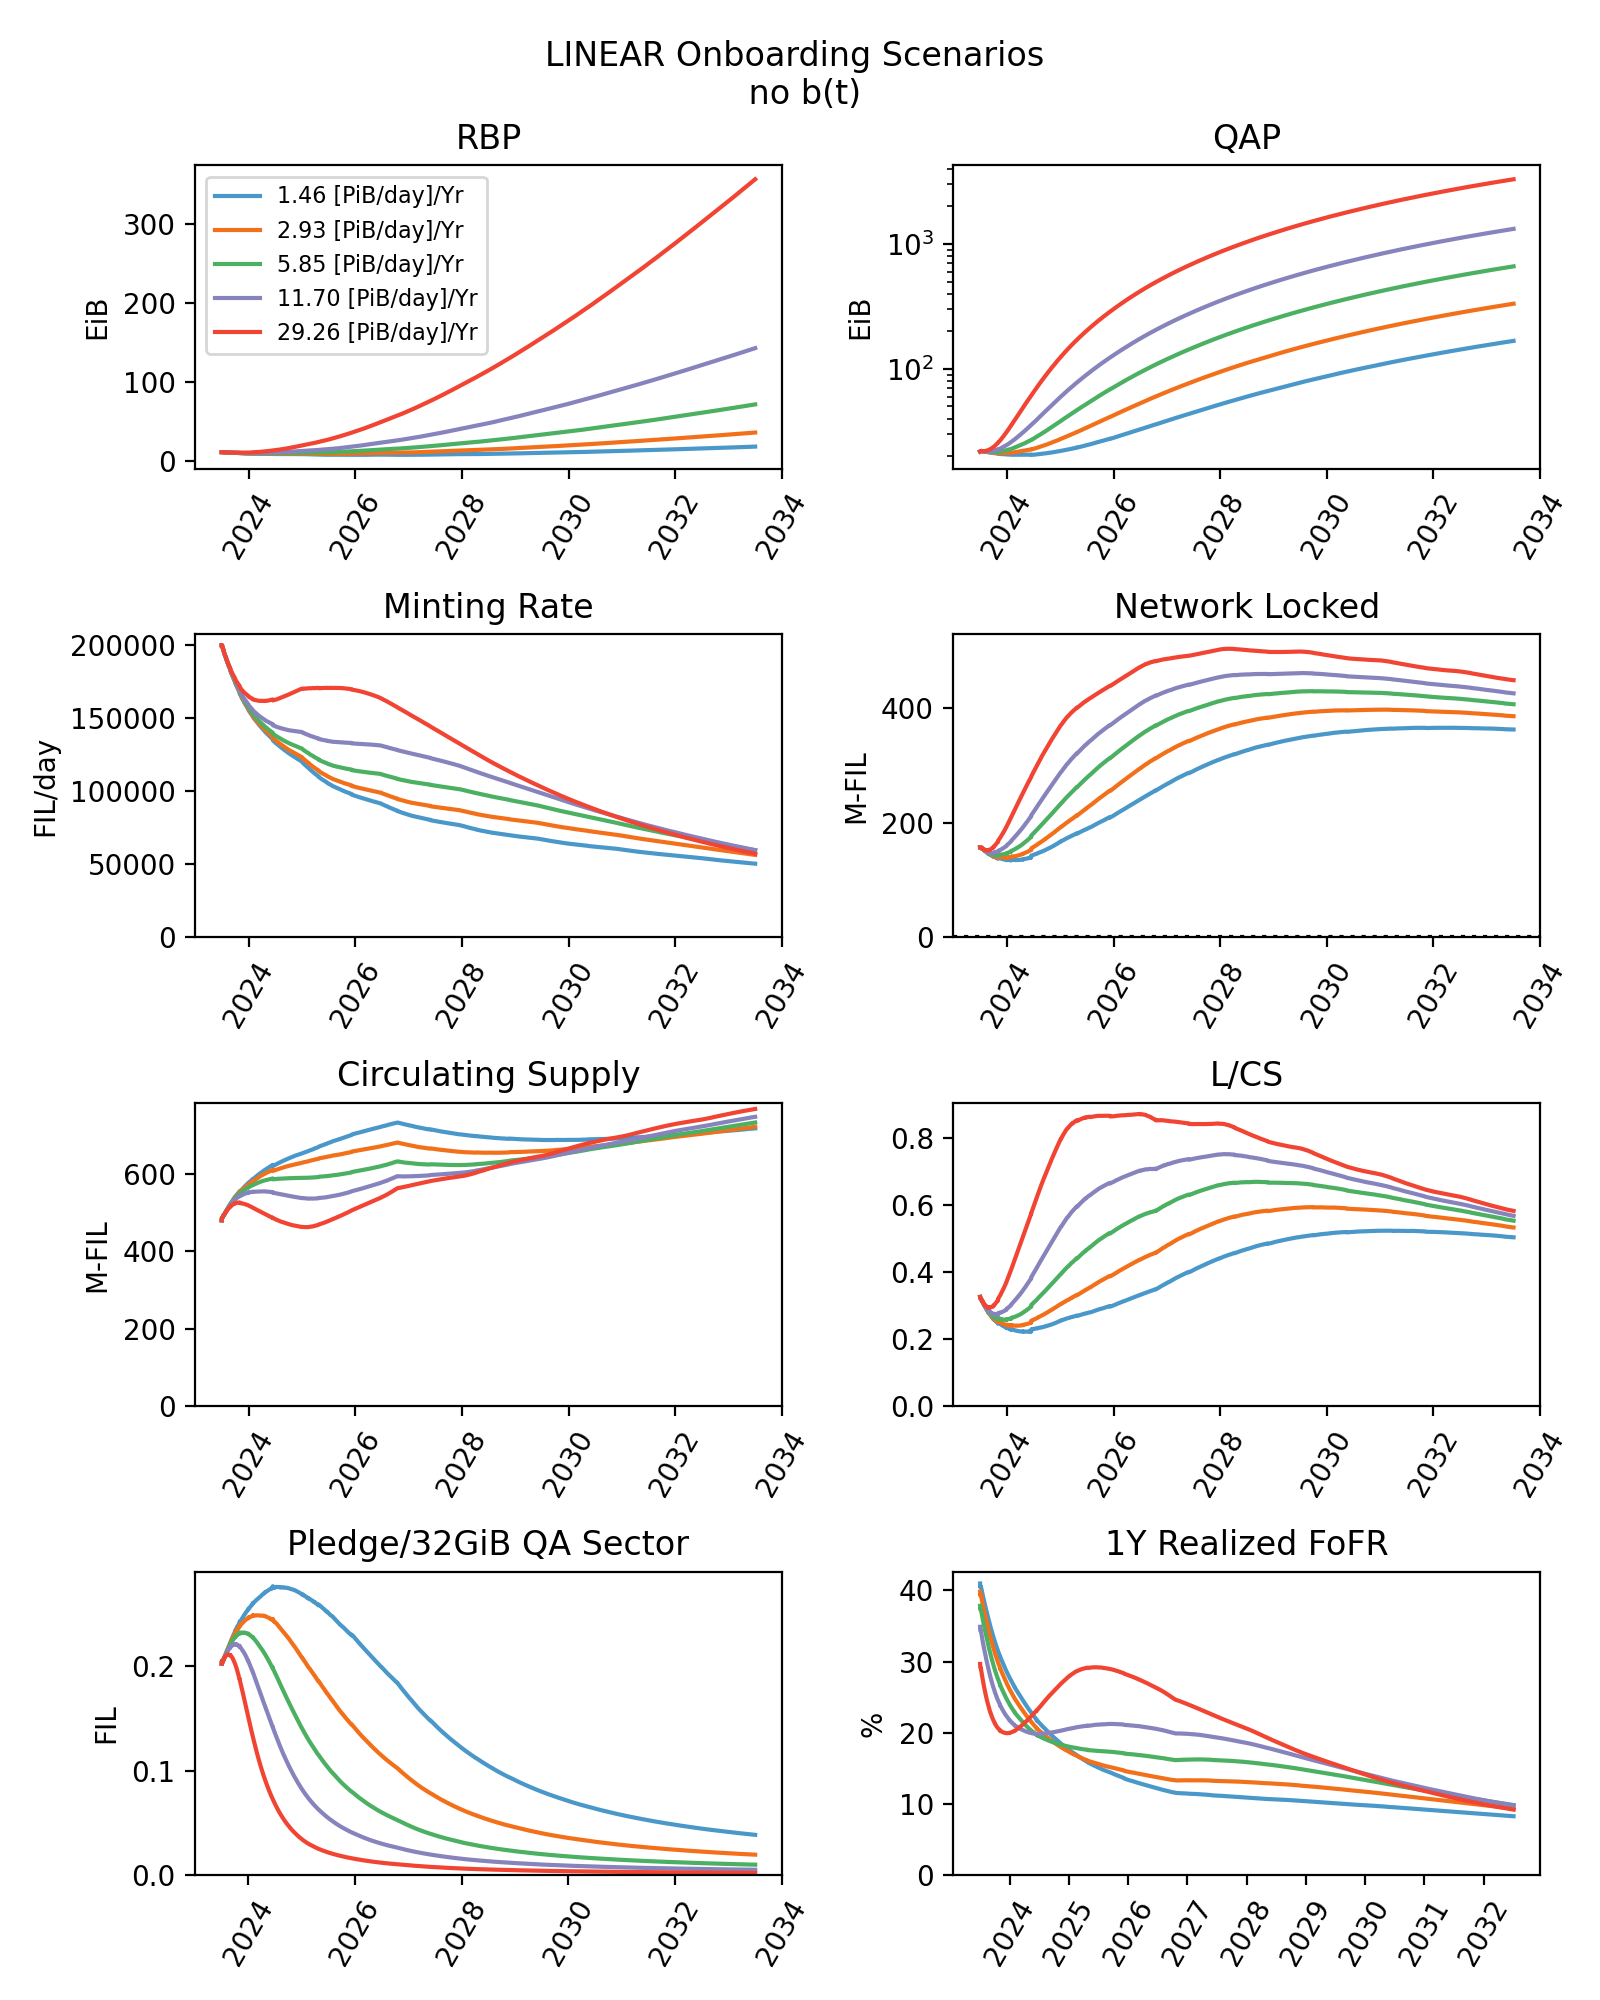

In [105]:
plot_scenario_results(key='linear', log_scale_power=False, labels=linear_labels)

<IPython.core.display.Javascript object>


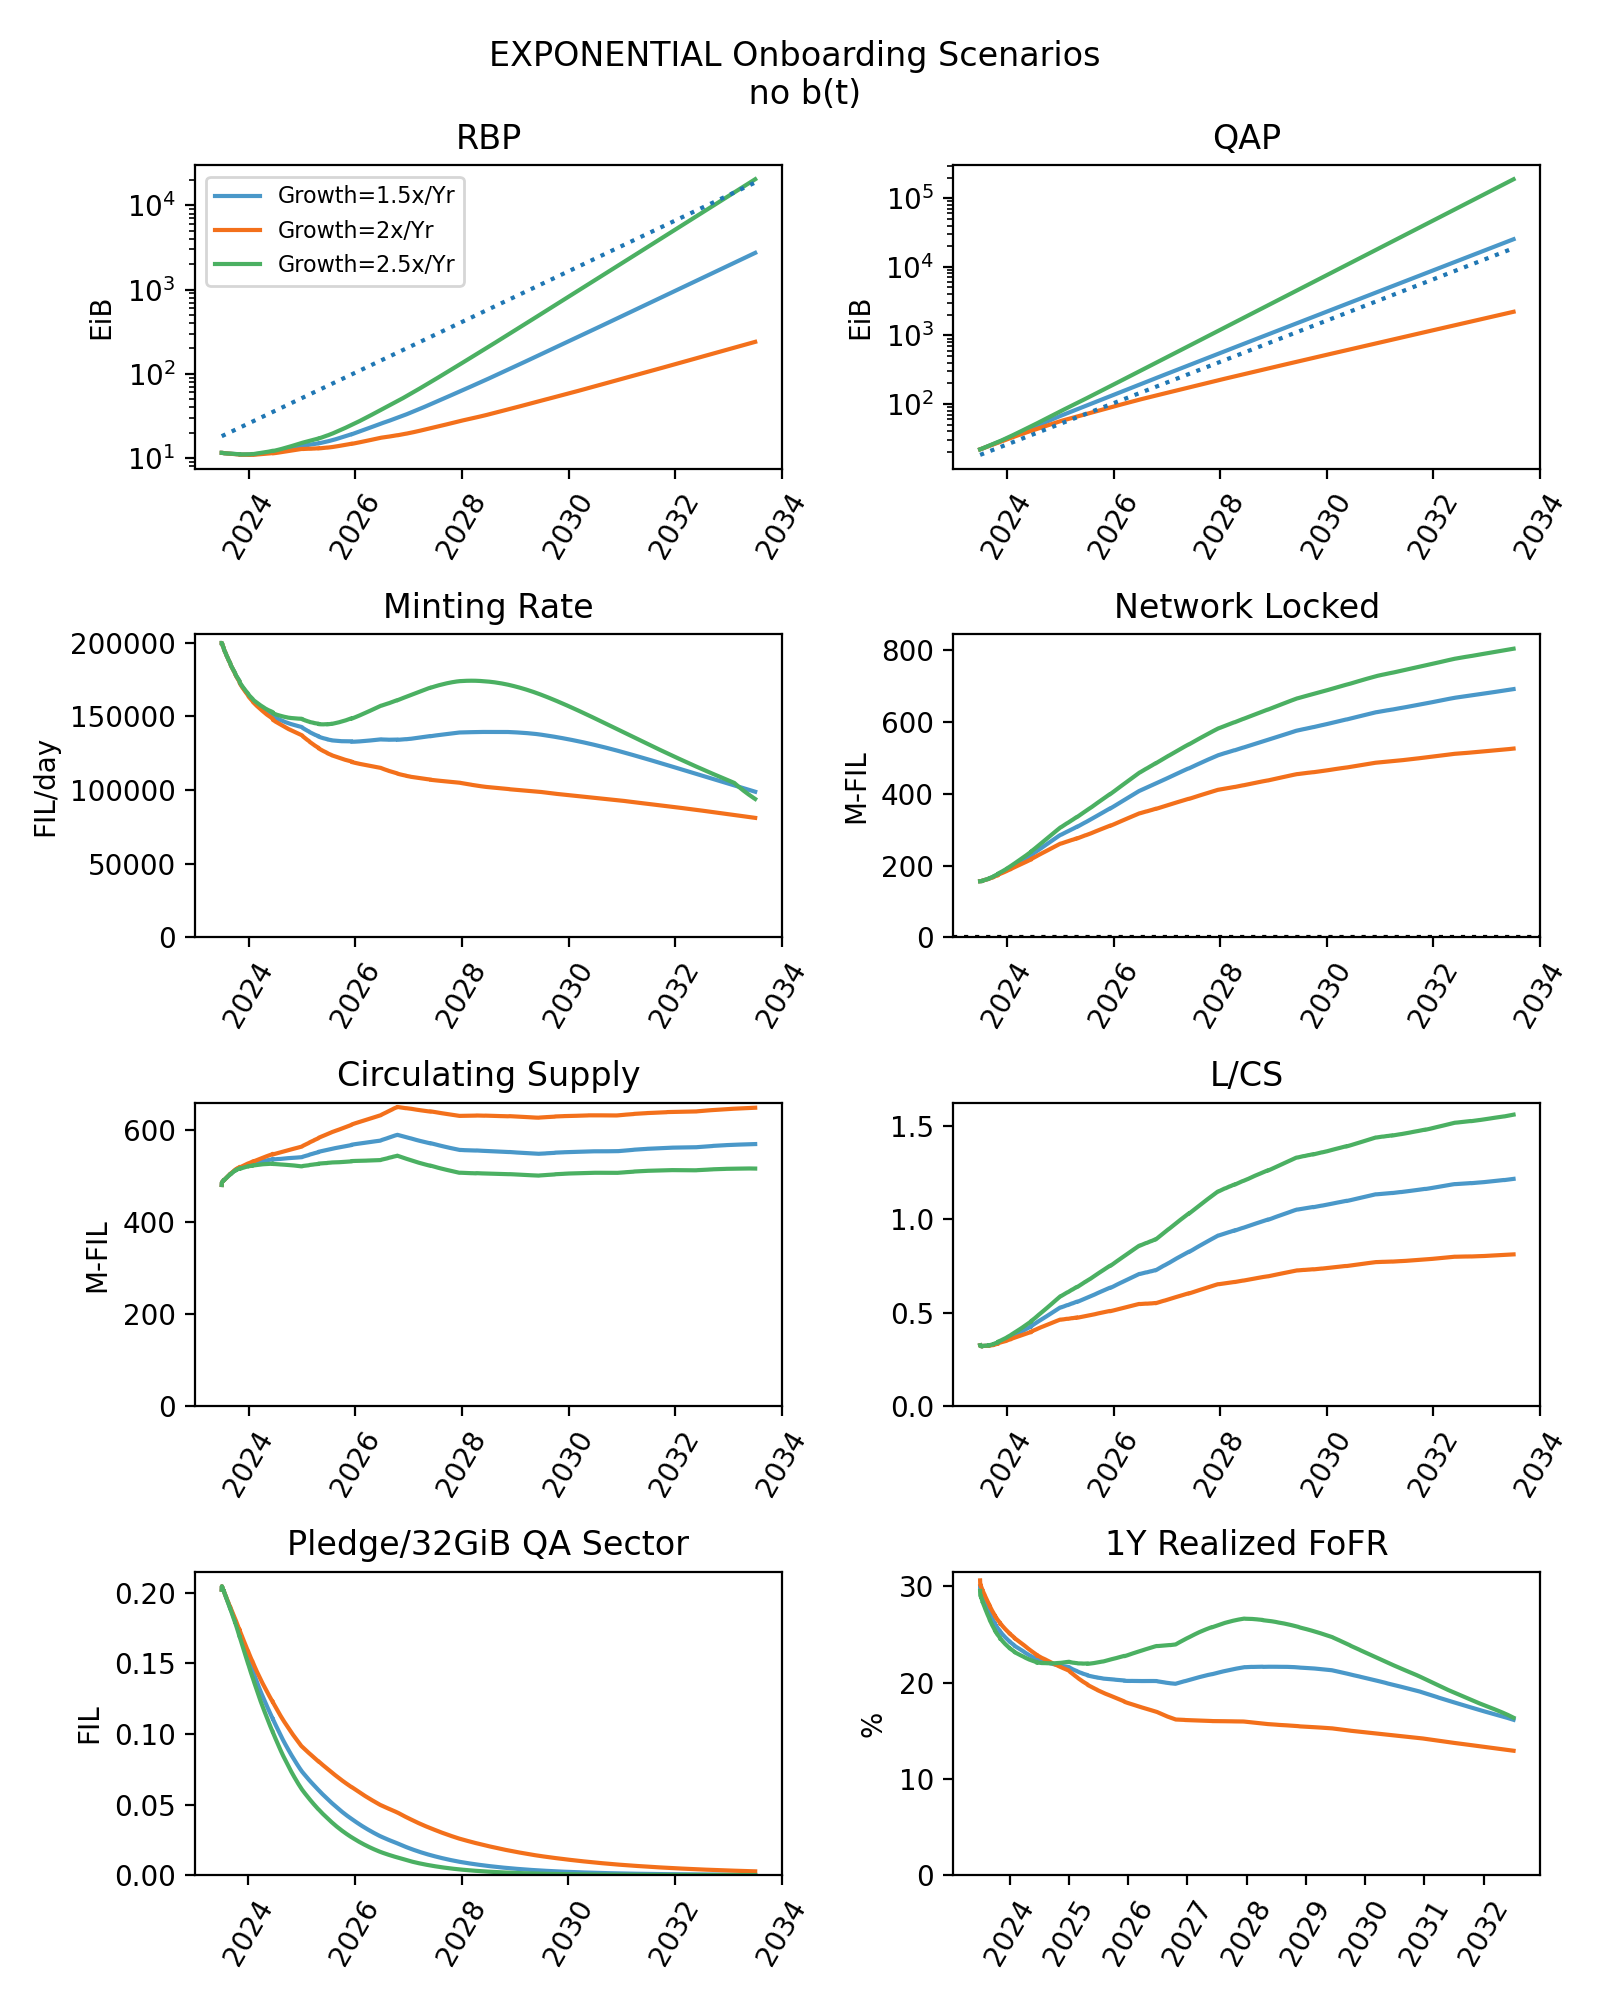

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_21258/4077052459.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axx.set_ylim(0)
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_21258/4077052459.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axx.set_ylim(0)


In [106]:
plot_scenario_results(key='exponential', log_scale_power=True, labels=exp_labels)